In [1]:
options(warn=-1)

# import required library
if (!require(dummies)) {
    install.packages("dummies")
}
if (!require(DAAG)) {
    install.packages("DAAG")
}
if (!require(xgboost)) {
    install.packages("xgboost")
}
if (!require(randomForest)) {
    install.packages("randomForest")
}
if (!require(gbm)) {
    install.packages("gbm")
}
if (!require(glmnet)) {
    install.packages("glmnet")
}
library(xgboost)       # XGBoost model
library(randomForest)  # Random Forest model
library(gbm)           # GBM model
library(dummies)       # Dummy variable
library(DAAG)          # Cross-Validation
library(glmnet)        # Logistic regression with Lasso

Loading required package: dummies
dummies-1.5.6 provided by Decision Patterns

Loading required package: DAAG
Loading required package: lattice
Loading required package: xgboost
Loading required package: randomForest
randomForest 4.6-12
Type rfNews() to see new features/changes/bug fixes.
Loading required package: gbm
Loading required package: survival

Attaching package: ‘survival’

The following object is masked from ‘package:DAAG’:

    lung

Loading required package: splines
Loading required package: parallel
Loaded gbm 2.1.1
Loading required package: glmnet
Loading required package: Matrix
Loading required package: foreach
Loaded glmnet 2.0-5



In [2]:
# load the data set
data = read.csv('./data/loan.csv')
# data.2016 = read.csv('./data/2016AllData.csv')

# Pre-processing and feature selection

In [3]:
# change the loan status
default.y = c('Default', 'Charged Off', 'Late (31-120 days)', 'Late (16-30 days)', 
              'Does not meet the credit policy. Status:Charged Off')
data$loan_status = ifelse(data$loan_status %in% default.y, 1, 0)

# -----------------------------------------------------------
# drop columns that have too many missing values
drop.names = c("mths_since_last_delinq", "mths_since_last_record", "mths_since_last_major_derog", 
               "annual_inc_joint", "dti_joint", "open_acc_6m", "open_il_6m", "open_il_12m", 
               "open_il_24m", "mths_since_rcnt_il", "total_bal_il", "il_util", "open_rv_12m", 
               "open_rv_24m", "max_bal_bc", "all_util", "inq_fi", "total_cu_tl", "inq_last_12m")
data = data[, !(names(data) %in% drop.names)]

# Transform categorical feature into numerical feature
data$sub_grade = as.numeric(data$sub_grade)

# -----------------------------------------------------------
# Drop useless features
# drop useless categorical features
drop.names = c("emp_title", "issue_d", "pymnt_plan", "url", "desc", "title", "zip_code", "addr_state", 
               "earliest_cr_line", "last_pymnt_d", "next_pymnt_d", "last_credit_pull_d", "application_type", 
               "verification_status_joint", "grade")
data = data[, !(names(data) %in% drop.names)]

# drop useless numerical features
drop.names = c("id", "member_id", "policy_code")
data = data[, !(names(data) %in% drop.names)]

# -----------------------------------------------------------
# Data Structures
# find all categorical and numerical variables
data.type = sapply(data, class)
cat.var = names(data)[which(data.type == 'factor')]
num.var = names(data)[which((data.type == 'integer') | (data.type == 'numeric'))]

# -----------------------------------------------------------
# Fill NA values
# create new feature named "NA" for categorical variables
for (i in cat.var) {
    data[, i] = addNA(data[, i])
}

# create new feature using the median value for numerical variables
for (i in num.var) {
    na.id = is.na(data[, i])
    tmp.median = median(data[, i], na.rm=TRUE)
    data[which(na.id), i] = tmp.median
}

# -----------------------------------------------------------
# Skewness
skew = c('installment', 'annual_inc', 'dti', 'revol_bal', 'total_acc', 'out_prncp', 'out_prncp_inv', 
         'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 
         'recoveries', 'collection_recovery_fee', 'last_pymnt_amnt', 'tot_coll_amt', 'tot_cur_bal',
         'total_rev_hi_lim')
for (i in skew){
    data[, i] = log(data[, i] + 1)
}

# -----------------------------------------------------------
# Dummy Variables

In [4]:
# create dummy variables
dummy.var = data.frame(dummy.data.frame(data[, cat.var], sep='.'))
data = cbind(data, dummy.var)

# drop original categorical variables
data = data[ , !(names(data) %in% cat.var)]

In [5]:
scale = function(score) {
    # function to scale the score
    score[which(score < 1e-15)] = 1e-15
    score[which(score > 1 - 1e-15)] = 1 - 1e-15
    score
}

# Vanilla Logistic Model

In [6]:
start.time = Sys.time()  # get time information

# fit the logistic model
log.model = glm(loan_status ~ ., data=data, family=binomial)

end.time = Sys.time()
cat('Start time:\t', as.character(start.time), '\n')
cat('End time:\t', as.character(end.time), '\n')
cat('Total time:\t', end.time - start.time, '\n')

Start time:	 2017-04-02 10:46:06 
End time:	 2017-04-02 10:49:35 
Total time:	 3.47799 


In [7]:
# calculate log-loss
y.hat = predict(log.model, data, type="response")
y.hat = scale(y.hat)
y = data$loan_status
loss = -sum(y * log(y.hat)) / length(y)
loss

[1] 0.06799766

In [8]:
# Logistic Model with Lasso

# # transform into matrix
# idx = which(names(data) == "loan_status")
# x = data.matrix(data[, -idx])
# y = data$loan_status

# # Cross Validation
# log.cv = cv.glmnet(x[1:10000, ], y[1:10000], family="binomial", alpha=1)
# plot(log.cv)

# log.cv$lambda.min
# log.cv$lambda.1se

# # fit the logistic model with Lasso
# log.model = glmnet(x, y, family="binomial", alpha=1, lambda=log.cv$lambda.1se)

# # calculate log-loss
# y.hat = predict(log.model, s=log.cv$lambda.1se, newx=x, type="response")
# y = data$loan_status
# loss = -sum(y * log(y.hat)) / length(y)
# loss

# GBM

[1] 655

Start time:	 2017-04-02 10:49:38 
End time:	 2017-04-02 13:33:27 
Total time:	 2.730387 


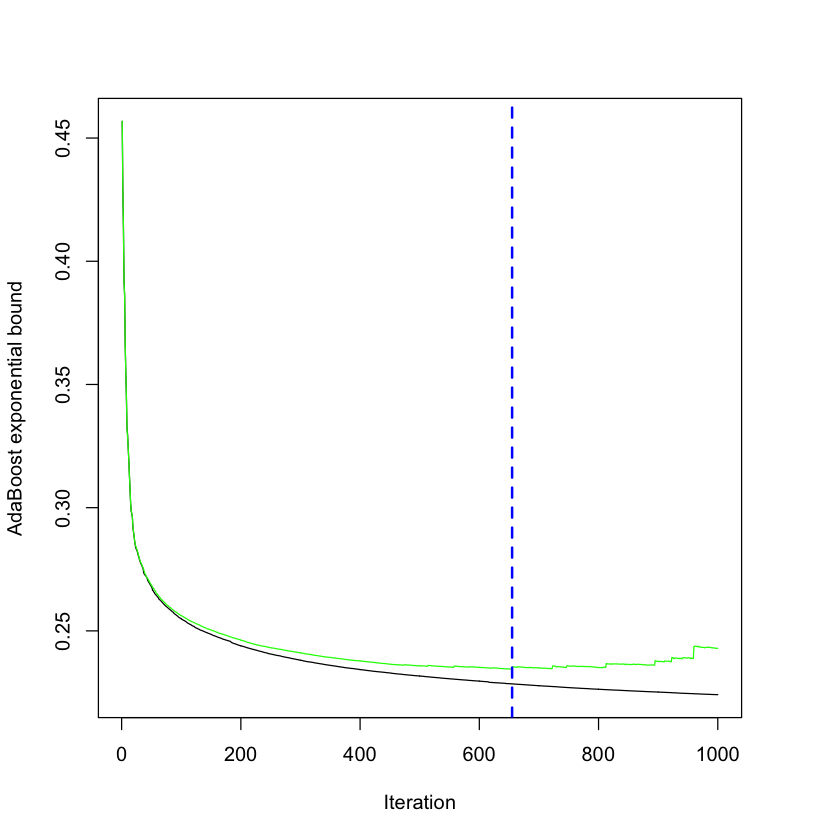

In [9]:
start.time = Sys.time()  # get time information

# build the adaboost model
ada.boost = gbm(loan_status ~ ., data=data, distribution="adaboost", n.trees=1000, 
                shrinkage=0.5, bag.fraction=1, cv.folds=5, n.cores=8)
gbm.perf(ada.boost, method='cv', plot.it=T)  # estimating the best iterations

end.time = Sys.time()
cat('Start time:\t', as.character(start.time), '\n')
cat('End time:\t', as.character(end.time), '\n')
cat('Total time:\t', end.time - start.time, '\n')

In [10]:
# calculate log-loss
y.hat = predict(ada.boost, data, type='response')
y.hat = scale(y.hat)
y = data$loan_status
loss = -sum(y * log(y.hat)) / length(y)
loss

Using 655 trees...


[1] 0.06534574

# Random Forest

In [11]:
start.time = Sys.time()  # get time information

# build the random forest model
rf.model = randomForest(as.factor(loan_status) ~ ., data=data, importance=T, ntree=100)

end.time = Sys.time()
cat('Start time:\t', as.character(start.time), '\n')
cat('End time:\t', as.character(end.time), '\n')
cat('Total time:\t', end.time - start.time, '\n')

Start time:	 2017-04-02 13:33:39 
End time:	 2017-04-02 15:37:26 
Total time:	 2.063305 


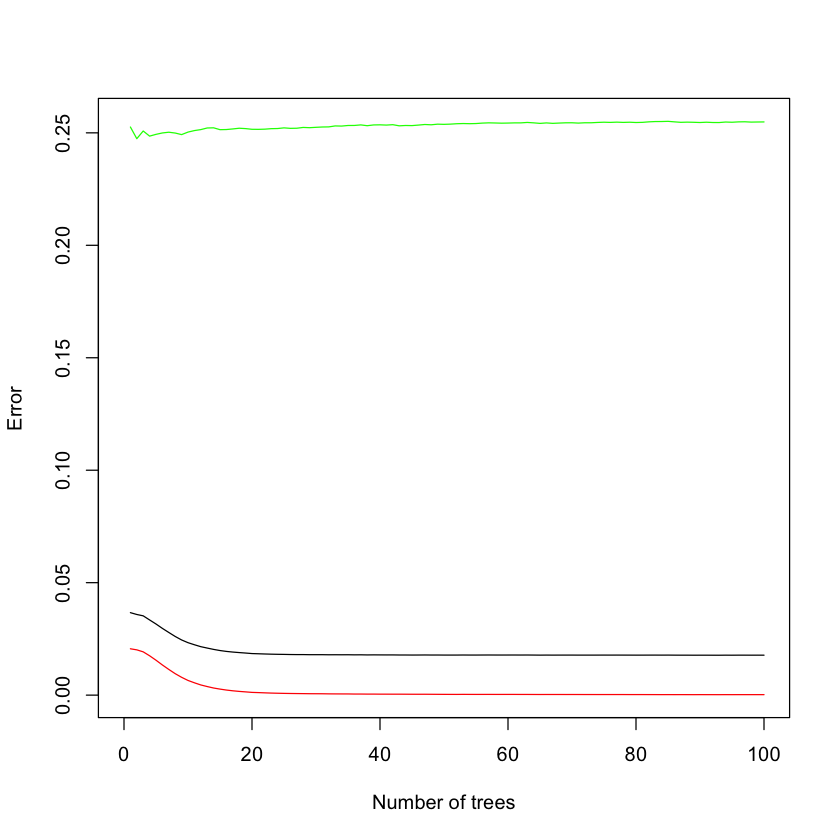

In [12]:
# plot the error rate
tmp = rf.model$err.rate
plot(c(0, rf.model$ntree), range(tmp), type="n",
     xlab = "Number of trees", ylab="Error")
lines(tmp[,1], col="black")
lines(tmp[,2], col="red")
lines(tmp[,3], col="green")

In [13]:
# calculate log-loss
y.hat = predict(rf.model, data, type="prob")[, 2]
y.hat = scale(y.hat)
y = data$loan_status
loss = -sum(y * log(y.hat)) / length(y)
loss

[1] 0.007916342

# XGBoost

In [14]:
data.y = data$loan_status
data.x = data[, -which(names(data) == "loan_status")]
data.x = apply(data.x, 2, as.numeric)

In [15]:
start.time = Sys.time()  # get time information

# build XGBoost model
set.seed(2017)
cv.dummy = xgb.cv(data=data.x, label=data.y, nfold=5, max.depth=6, eta=0.5, 
                  nrounds=200, nthread=8, early.stop.round=3, verbose=T,
                  objective="binary:logistic", metrics=list("logloss"))

end.time = Sys.time()
cat('Start time:\t', as.character(start.time), '\n')
cat('End time:\t', as.character(end.time), '\n')
cat('Total time:\t', end.time - start.time, '\n')

[1]	train-logloss:0.348135+0.000070	test-logloss:0.348205+0.000152 
Multiple eval metrics are present. Will use test_logloss for early stopping.
Will train until test_logloss hasn't improved in 3 rounds.

[2]	train-logloss:0.218787+0.000155	test-logloss:0.218907+0.000232 
[3]	train-logloss:0.157668+0.000171	test-logloss:0.157836+0.000302 
[4]	train-logloss:0.123135+0.000152	test-logloss:0.123367+0.000358 
[5]	train-logloss:0.102843+0.000186	test-logloss:0.103119+0.000509 
[6]	train-logloss:0.091926+0.000760	test-logloss:0.092258+0.000954 
[7]	train-logloss:0.086022+0.000409	test-logloss:0.086432+0.000863 
[8]	train-logloss:0.082634+0.000607	test-logloss:0.083126+0.000910 
[9]	train-logloss:0.080451+0.000323	test-logloss:0.081043+0.000673 
[10]	train-logloss:0.079108+0.000604	test-logloss:0.079802+0.000620 
[11]	train-logloss:0.077564+0.000355	test-logloss:0.078356+0.000558 
[12]	train-logloss:0.076686+0.000191	test-logloss:0.077596+0.000854 
[13]	train-logloss:0.075980+0.000313	test-lo

In [18]:
start.time = Sys.time()  # get time information

bst = xgboost(data=data.x, label=data.y, max.depth=6, eta=0.5, nrounds=85, 
              nthread=8, objective="binary:logistic", verbose=F)

end.time = Sys.time()
cat('Start time:\t', as.character(start.time), '\n')
cat('End time:\t', as.character(end.time), '\n')
cat('Total time:\t', end.time - start.time, '\n')

Start time:	 2017-04-02 18:52:10 
End time:	 2017-04-02 19:13:17 
Total time:	 21.11704 


In [19]:
# calculate log-loss
y.hat = predict(bst, data.x)
y.hat = scale(y.hat)
y = data$loan_status
loss = -sum(y * log(y.hat)) / length(y)
loss

[1] 0.04335343